In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from collections import Counter
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


Propertycrime = α + Population + Robbery + Bruglary + Larceny + Motor Vehicle Theft + Arson

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

In [2]:
df = pd.read_csv('C:\\Users\\david\Desktop\\thinkful datasets\\table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv', header=4,)

df
display(df.columns)

data= pd.DataFrame(df) 

#Identify columns needed for challenge
needed_data = data.loc[:, ['City','Population', 'Property\ncrime', 'Robbery','Burglary','Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'arson3' ]]
needed_data.columns = ['City','Population', 'Property_Crime', 'Robbery', 'Burglary', 'Larceny', 'Motor vehicle theft', 'Arson']

#arson column has null values. Change them to 0
needed_data.Arson = np.nan_to_num(needed_data.Arson)

needed_data = needed_data.dropna(axis=0, how='any')

needed_data.head(5)

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

c:\users\david\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
c:\users\david\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,City,Population,Property_Crime,Robbery,Burglary,Larceny,Motor vehicle theft,Arson
0,Adams Village,1861.000,12.000,0.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,24.000,0.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,16.000,0.000,1.000,15.000,0.000,0.000
3,Albany,97956.000,4090.000,227.000,705.000,3243.000,142.000,0.000
4,Albion Village,6388.000,223.000,4.000,53.000,165.000,5.000,0.000


In [3]:
needed_data.describe()

,Population,Property_Crime,Robbery,Burglary,Larceny,Motor vehicle theft,Arson
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,40037.632,792.606,72.902,119.684,637.017,35.905,0.000
std,450037.368,7659.725,1031.033,924.949,6346.054,403.424,0.000
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,40.500,0.000,6.000,31.000,0.000,0.000
50%,7233.500,112.500,1.000,17.500,94.000,2.000,0.000
75%,18427.500,341.000,5.000,51.250,287.250,7.000,0.000
max,8396126.000,141971.000,19170.000,16606.000,117931.000,7434.000,0.000


In [4]:
needed_data['Population'].max()

8396126.0

In [5]:
df.loc[needed_data['Population'].idxmax()]

City                                        New York
Population                               8396126.000
Violent\ncrime                             52384.000
Murder and\nnonnegligent\nmanslaughter       335.000
Rape\n(revised\ndefinition)1                     NaN
Rape\n(legacy\ndefinition)2                 1112.000
Robbery                                    19170.000
Aggravated\nassault                        31767.000
Property\ncrime                           141971.000
Burglary                                   16606.000
Larceny-\ntheft                           117931.000
Motor\nvehicle\ntheft                       7434.000
Arson3                                           NaN
Name: 216, dtype: object

In [6]:
df.loc[needed_data['Population'].idxmin()]

City                                      Glen Park Village
Population                                          526.000
Violent\ncrime                                        0.000
Murder and\nnonnegligent\nmanslaughter                0.000
Rape\n(revised\ndefinition)1                            NaN
Rape\n(legacy\ndefinition)2                           0.000
Robbery                                               0.000
Aggravated\nassault                                   0.000
Property\ncrime                                       5.000
Burglary                                              0.000
Larceny-\ntheft                                       5.000
Motor\nvehicle\ntheft                                 0.000
Arson3                                                0.000
Name: 118, dtype: object

In [7]:
#removing any outliers
needed_data = needed_data[np.abs(needed_data.Population-needed_data.Population.mean())<=(2*needed_data.Population.std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
#needed_data= needed_data[~(np.abs(needed_data.Population-needed_data.Population.mean())>(3*needed_data.Population.std()))] #or if you prefer the other way around


In [8]:
needed_data.describe()

,Population,Property_Crime,Robbery,Burglary,Larceny,Motor vehicle theft,Arson
count,347.000,347.000,347.000,347.000,347.000,347.000,347.000
mean,15956.686,385.752,17.867,72.173,298.994,14.585,0.000
std,27080.219,1034.369,94.972,264.941,715.232,67.682,0.000
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2997.000,40.000,0.000,6.000,31.000,0.000,0.000
50%,7187.000,112.000,1.000,17.000,94.000,2.000,0.000
75%,18160.500,340.500,5.000,51.000,284.500,7.000,0.000
max,258789.000,12491.000,1322.000,3458.000,8076.000,957.000,0.000


## Visulaize Data
Now that the data has been cleaned and the outliers removedlet's take a look at the relationships between the variables

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


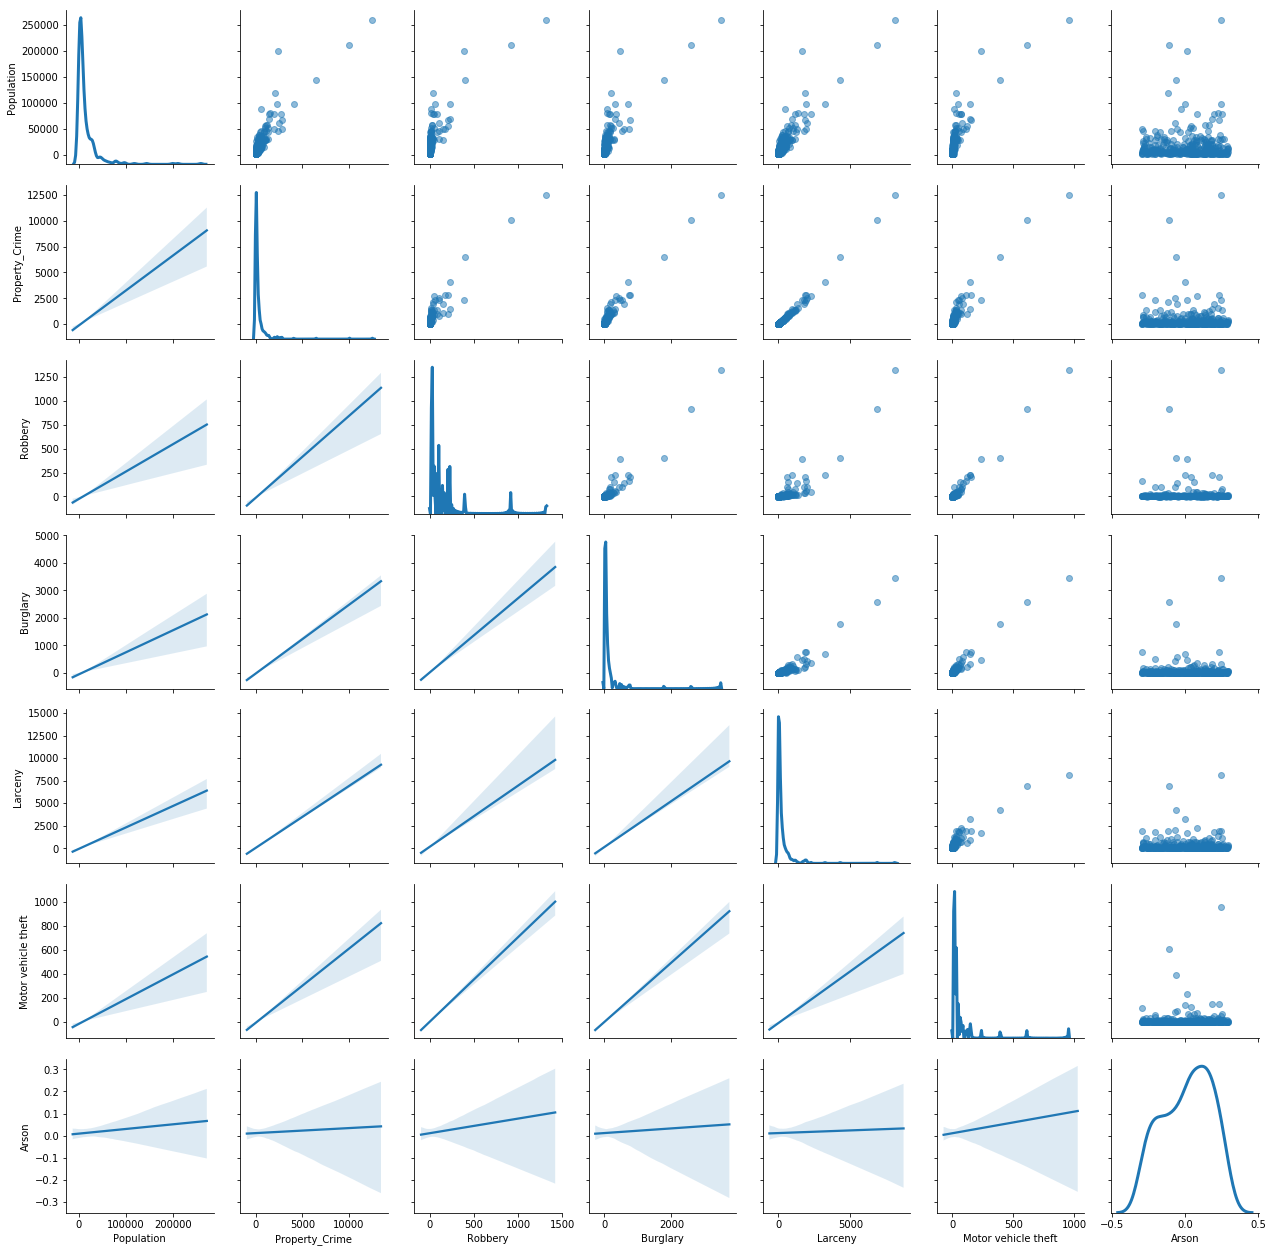

In [9]:

# Make a graph displaying the relationship of each of the continuous variables to each other. # Make a 
pop_data = needed_data.loc[:, 'Population':]

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(pop_data.shape)),
    columns=pop_data.columns
)
# Combine the data and the noise.
pop_data = pop_data.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(pop_data.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

# Multivariable Linear Regression Model
Using the the features that had the closest to libnear relationsship I will build a regression model. Note that arson did not show a great relationship to the target of property crime and it was removed


$$ Property crime = \alpha + Population + Robbery + Bruglary + Larceny + Motor vehicle theft$$

In [10]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = needed_data['Property_Crime'].values.reshape(-1, 1)
X = needed_data[['Population', 'Robbery', 'Burglary', 'Larceny']]
#X = needed_data[['Population', 'Property\ncrime', 'Robbery','Burglary','Larceny-\ntheft', 'Motor\nvehicle\ntheft']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

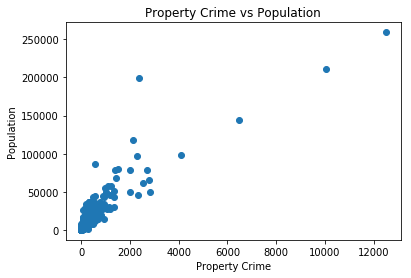

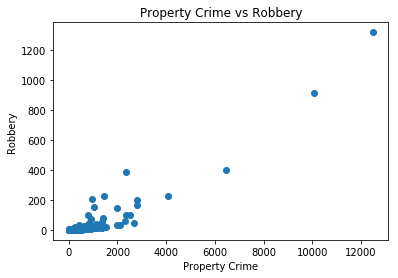

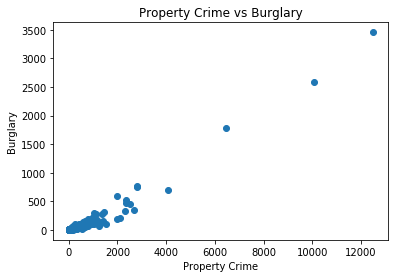

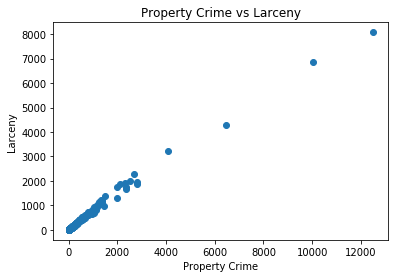


Coefficients: 
 [[1.72009833e-04 4.48847974e-01 1.10117274e+00 9.91695801e-01]]

Intercept: 
 [-0.99847814]

R-squared:
0.9999406091707272


In [11]:
for each in X:
    plt.scatter(needed_data['Property_Crime'], needed_data[each])
    plt.title('Property Crime vs ' + each)
    plt.xlabel('Property Crime')
    plt.ylabel(each)
    plt.show()
    
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

## Multivariate Normality
The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed. Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

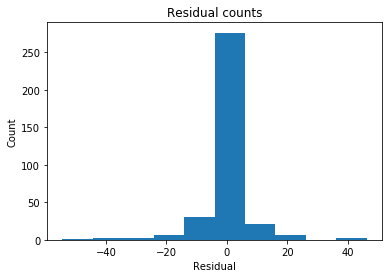

In [12]:

predicted = regr.predict(X).ravel()
actual = needed_data['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()


## Homoscedasticity
The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or **homoscedastic**.


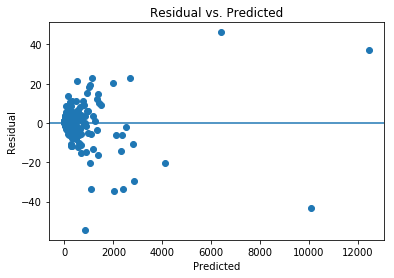

In [13]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Low multicollinearity

It looks like my data the features in my correlation are highly related with the lowest correlation at 0.816 

In [14]:
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Robbery,Burglary,Larceny
Population,1.000,0.816,0.820,0.901
Robbery,0.816,1.000,0.964,0.898
Burglary,0.820,0.964,1.000,0.950
Larceny,0.901,0.898,0.950,1.000


# Testing Our Model

In [15]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'Property_Crime ~ Population+Robbery+Burglary+Larceny'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=needed_data).fit()

Coefficients of the Model

In [16]:
lm.params

Intercept    -0.998
Population    0.000
Robbery       0.449
Burglary      1.101
Larceny       0.992
dtype: float64

P-Values of the coefficients

In [17]:
lm.pvalues

Intercept    0.071
Population   0.000
Robbery      0.000
Burglary     0.000
Larceny      0.000
dtype: float64

The R-Squared of the coefficients

In [18]:
lm.rsquared

0.9999406091707271

In [19]:
# Test my model with different holdout groups.
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
data_train, data_test, target_train, target_test = train_test_split(X, Y, test_size=0.30, random_state=42)

my_model = regr.fit(data_train, target_train)

# Classify, storing the result in a training variable and Fit our model to the data.
train_pred = my_model.predict(data_train)

# Display our Training results.
print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
training_score = r2_score(train_pred, target_train)
print(training_score)

# Classify, storing the result in a testing variable and Fit our model to the data.
test_pred = my_model.predict(data_test)

print('\nTesting R-squared:')
score = r2_score(test_pred, target_test)
print(score)


Training Coefficients: 
 [[1.60238800e-04 4.22901991e-01 1.10139165e+00 9.96639171e-01]]

Training Intercept: 
 [-1.46182512]

Training R-squared:
0.9999505866171411

Testing R-squared:
0.9998454659110896
